# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
from collections import defaultdict
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="./Banana_Windows_x86_64/Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
# env_info = env.reset(train_mode=False)[brain_name] # reset the environment
# state = env_info.vector_observations[0]            # get the current state
# score = 0                                          # initialize the score
# while True:
#     action = np.random.randint(action_size)        # select an action
#     env_info = env.step(action)[brain_name]        # send the action to the environment
#     next_state = env_info.vector_observations[0]   # get the next state
#     reward = env_info.rewards[0]                   # get the reward
#     done = env_info.local_done[0]                  # see if episode has finished
#     score += reward                                # update the score
#     state = next_state                             # roll over the state to next time step
#     if done:                                       # exit loop if episode finished
#         break
    
# print("Score: {}".format(score))

When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [35]:
from model import QNetwork
from dqn_agent import Agent
import torch

In [30]:
import math
import sys
from collections import deque

def interact(unity_env, agent, num_episodes=20000, window=100):
    """ Monitor agent's performance.
    
    Params
    ======
    - unity_env: instance of Banana Collector Environment
    - agent: instance of class Agent (see dqn_agent.py for details)
    - num_episodes: maximum number of episodes of agent-environment interaction
    - window: number of episodes to consider when calculating average rewards

    Returns
    =======
    - avg_rewards: deque containing average rewards
    - best_avg_reward: largest value in the avg_rewards deque
    """
    # initialize average rewards
    avg_rewards = deque(maxlen=num_episodes)
    # initialize best average reward
    best_avg_reward = -math.inf
    # initialize monitor for most recent rewards
    samp_rewards = deque(maxlen=window)
    # for each episode
    for i_episode in range(1, num_episodes+1):
        
        # begin the episode
        env_info = unity_env.reset(train_mode=True)[brain_name] # reset the unity environment
        
        # initial state
        state = env_info.vector_observations[0]  
        # initialize the sampled reward for this episode
        samp_reward = 0
        
        while True:
            # agent selects an action using epsilon-greedy policy
            # need conversion from 64bit to 32bit int, otherwise error in unity
            action = agent.act(state).astype(int)
            
            # agent performs the selected action
            env_info = unity_env.step(action)[brain_name]     

            # perform action and save next_state and reward
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]  # get the reward
            done = env_info.local_done[0] # is episode over?
            
            # agent performs internal updates based on sampled experience
            agent.step(state, action, reward, next_state, done)
            
            # update the sampled reward
            samp_reward += reward
            
            # update the state (s <- s') to next time step
            state = next_state
            if done:
                # save final sampled reward
                samp_rewards.append(samp_reward)
                break
        if (i_episode >= 0):
            # get average reward from last 100 episodes
            avg_reward = np.mean(samp_rewards)
            # append to deque
            avg_rewards.append(avg_reward)
            # update best average reward
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
        # monitor progress
        print("\rEpisode {}/{} || Best average reward {}".format(i_episode, num_episodes, best_avg_reward), end="")
        sys.stdout.flush()
        # check if task is solved (according to Udacity DRLND instructions)
        if best_avg_reward >= 13:
            print('\nEnvironment solved in {} episodes.'.format(i_episode), end="")
            break
        if i_episode == num_episodes: print('\n')
    return avg_rewards, best_avg_reward

In [32]:
agent_eps = Agent(state_size=state_size, action_size=action_size, seed=42)
avg_rewards_eps, best_avg_reward_eps = interact(env, agent_eps, num_episodes=3000)

Episode 372/3000 || Best average reward 13.01666666666665
Environment solved in 372 episodes.

Text(0.5, 0.98, 'Scores against Episode #')

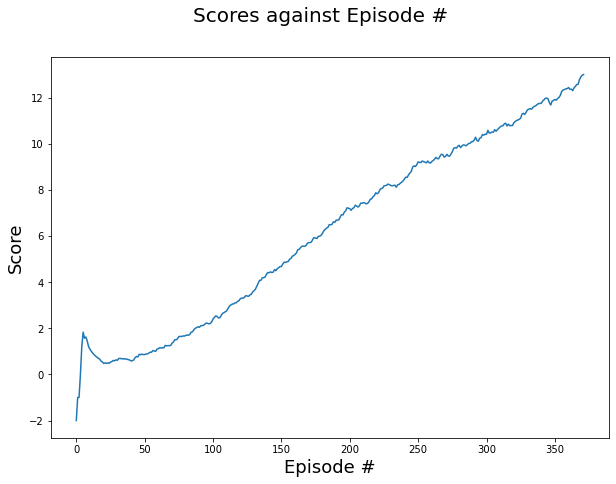

In [33]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,7))
plt.xlabel('Episode #', fontsize=18)
plt.ylabel('Score', fontsize=18)
plt.plot(avg_rewards_eps)
fig.suptitle('Scores against Episode #', fontsize=20)

In [40]:
torch.save(agent_eps.qnetwork_local.state_dict(), './2020_05_14_qnetwork_lokal.pt')

In [41]:
torch.save(agent_eps.qnetwork_target.state_dict(), './2020_05_14_qnetwork_target.pt')

In [42]:
env.close()